In [1]:
# =============================================================================
# SIMULAÇÃO ELETROTÉRMICA DE FUSÍVEL - ACOPLAMENTO FRACO (SEGUINDO O FLUXOGRAMA)
# =============================================================================

import numpy as np
import gmsh
import ufl
from mpi4py import MPI
from petsc4py import PETSc
import matplotlib.pyplot as plt
import pyvista

# Imports do FEniCS/DOLFINx
from dolfinx import default_scalar_type, fem
from dolfinx.fem import (
    Constant, Function, functionspace, assemble_scalar, dirichletbc, form, locate_dofs_topological, Expression
)
from dolfinx.fem.petsc import LinearProblem
from dolfinx.io import gmshio
from dolfinx.mesh import locate_entities_boundary, meshtags, exterior_facet_indices
from dolfinx.plot import vtk_mesh

In [2]:
# =============================================================================
# 1. INICIALIZAÇÃO: GEOMETRIA E PARÂMETROS DO MODELO
# =============================================================================

# --- Parâmetros Elétricos
V0_calibracao = 0.1   # (V) Tensão usada apenas para calibrar a resistência inicial

# --- Geometria do Fusível (m)
x_bar = 5.2e-3
y_bar = 16.3e-3
x_gap = 4.1e-3
y_filamento = 6.5e-4
espessura_lamina = 6.5e-4

# --- Propriedades do Material (Estanho)
sigma0 = 8.7e6        # (S/m) Condutividade elétrica na temperatura de referência T0
alpha_r = 0.0045      # (1/K) Coeficiente de temperatura da resistividade
rho = 7298.0          # (kg/m³) Densidade
Cp = 227.0            # (J/kg⋅K) Calor específico
k_thermal = 66.6      # (W/m⋅K) Condutividade térmica
Tf = 231.97 + 273.15  # (K) Temperatura de fusão

# --- Condições Ambientais e de Simulação
T0 = 25.0 + 273.15    # (K) Temperatura de referência para sigma0
T_amb = 25.0 + 273.15 # (K) Temperatura ambiente
h_conv = 15.0         # (W/m²⋅K) Coeficiente de convecção

# --- Configurações da Simulação
comm = MPI.COMM_WORLD
gdim = 2
model_rank = 0

In [3]:
# =============================================================================
# 1.1 INICIALIZAÇÃO: CRIAÇÃO DA GEOMETRIA E MALHA
# =============================================================================

def geometria(x_gap):
    gmsh.initialize()
    if comm.rank == model_rank:
        gmsh.model.add("fusivel")
        
        terminal1 = gmsh.model.occ.addRectangle(0, 0, 0, x_bar, y_bar)
        terminal2 = gmsh.model.occ.addRectangle(x_bar + x_gap, 0, 0, x_bar, y_bar)
        y_filamento_pos = y_bar * 0.4 
        f1 = gmsh.model.occ.addRectangle(x_bar, y_filamento_pos, 0, x_gap / 4, y_filamento)
        f2 = gmsh.model.occ.addRectangle(x_bar + 3 * x_gap / 4, y_filamento_pos, 0, x_gap / 4, y_filamento)
        f3 = gmsh.model.occ.addRectangle(x_bar + x_gap / 4 - y_filamento, y_filamento_pos + y_filamento, 0, y_filamento, y_bar * 0.2)
        f4 = gmsh.model.occ.addRectangle(x_bar + 3 * x_gap / 4, y_filamento_pos + y_filamento, 0, y_filamento, y_bar * 0.2)
        f5 = gmsh.model.occ.addRectangle(x_bar + x_gap / 4, y_filamento_pos + y_bar * 0.2, 0, x_gap / 2, y_filamento)
        entidades = [(2, terminal1), (2, terminal2), (2, f1), (2, f2), (2, f3), (2, f4), (2, f5)]
        _, omap = gmsh.model.occ.fragment(entidades, [])
        gmsh.model.occ.synchronize()

        vols = gmsh.model.getEntities(dim=2)
        terminal1_ids, terminal2_ids, filamento_ids = [], [], []
        for vol in vols:
            com = gmsh.model.occ.getCenterOfMass(vol[0], vol[1])
            if com[0] < x_bar:
                terminal1_ids.append(vol[1])
            elif com[0] > x_bar + x_gap:
                terminal2_ids.append(vol[1])
            else:
                filamento_ids.append(vol[1])
        
        gmsh.model.addPhysicalGroup(2, terminal1_ids, 1); gmsh.model.setPhysicalName(2, 1, "Terminal1")
        gmsh.model.addPhysicalGroup(2, terminal2_ids, 2); gmsh.model.setPhysicalName(2, 2, "Terminal2")
        gmsh.model.addPhysicalGroup(2, filamento_ids, 3); gmsh.model.setPhysicalName(2, 3, "Filamento")
        
        gmsh.option.setNumber("Mesh.CharacteristicLengthMax", x_gap / 32)
        gmsh.model.mesh.generate(gdim)
        
        mesh, cell_tags, facet_tags = gmshio.model_to_mesh(gmsh.model, comm, model_rank, gdim=gdim)
    else:
        mesh, cell_tags, facet_tags = gmshio.model_to_mesh(None, comm, model_rank, gdim=gdim)
        
    gmsh.finalize()
    return mesh, cell_tags, facet_tags

mesh, cell_tags, facet_tags = geometria(x_gap)

Info    : Meshing 1D...                                                                                                                         
Info    : [  0%] Meshing curve 12 (Line)
Info    : [ 10%] Meshing curve 14 (Line)
Info    : [ 10%] Meshing curve 15 (Line)
Info    : [ 20%] Meshing curve 16 (Line)
Info    : [ 20%] Meshing curve 17 (Line)
Info    : [ 20%] Meshing curve 18 (Line)
Info    : [ 30%] Meshing curve 19 (Line)
Info    : [ 30%] Meshing curve 20 (Line)
Info    : [ 30%] Meshing curve 21 (Line)
Info    : [ 40%] Meshing curve 22 (Line)
Info    : [ 40%] Meshing curve 23 (Line)
Info    : [ 40%] Meshing curve 24 (Line)
Info    : [ 50%] Meshing curve 25 (Line)
Info    : [ 50%] Meshing curve 26 (Line)
Info    : [ 50%] Meshing curve 27 (Line)
Info    : [ 60%] Meshing curve 28 (Line)
Info    : [ 60%] Meshing curve 29 (Line)
Info    : [ 60%] Meshing curve 30 (Line)
Info    : [ 70%] Meshing curve 31 (Line)
Info    : [ 70%] Meshing curve 32 (Line)
Info    : [ 70%] Meshing curve 33 (

In [4]:
# =============================================================================
# 1.2 INICIALIZAÇÃO: ESPAÇOS DE FUNÇÃO E CONDIÇÕES DE CONTORNO
# =============================================================================

V_ele = functionspace(mesh, ("Lagrange", 1)) 
V_T = functionspace(mesh, ("Lagrange", 1))   
Q = functionspace(mesh, ("DG", 0))           
W_ele = functionspace(mesh, ("Lagrange", 1, (gdim,)))

# --- Funções para armazenar soluções e propriedades ---
T_n = Function(V_T, name="Temperatura_passo_anterior")
mu = Function(Q, name="Condutividade_Eletrica")
q_source = Function(Q, name="Fonte_Calor")
q_source_initial = Function(Q, name="Fonte_Calor_Inicial")
E_field = Function(W_ele, name="Campo_Eletrico")

# --- Condições de Contorno ---
facets_base = locate_entities_boundary(mesh, gdim - 1, lambda x: np.isclose(x[1], 0))
dofs_base_ele = locate_dofs_topological(V_ele, gdim - 1, facets_base)
uD = Function(V_ele)

T_amb_const = Constant(mesh, default_scalar_type(T_amb))
dofs_base_term = locate_dofs_topological(V_T, gdim - 1, facets_base)
bc_term = dirichletbc(T_amb_const, dofs_base_term, V_T)

boundary_facets = exterior_facet_indices(mesh.topology)
convection_facets = np.setdiff1d(boundary_facets, facets_base)
convection_tags = meshtags(mesh, gdim-1, convection_facets, 1)
ds_conv = ufl.ds(domain=mesh, subdomain_data=convection_tags, subdomain_id=1)

In [5]:
# =============================================================================
# 1.3 INICIALIZAÇÃO: FORMULAÇÕES FRACAS
# =============================================================================

# --- Elétrica ---
phi = ufl.TrialFunction(V_ele)
v = ufl.TestFunction(V_ele)
a_ele = mu * ufl.dot(ufl.grad(phi), ufl.grad(v)) * ufl.dx
L_ele = Constant(mesh, default_scalar_type(0.0)) * v * ufl.dx

# --- Térmica Transiente ---
T = ufl.TrialFunction(V_T)
w = ufl.TestFunction(V_T)
dt = Constant(mesh, default_scalar_type(0.05)) 
rho_const = Constant(mesh, default_scalar_type(rho))
Cp_const = Constant(mesh, default_scalar_type(Cp))
k_const = Constant(mesh, default_scalar_type(k_thermal))
h_const = Constant(mesh, default_scalar_type(h_conv))

a_T = (rho_const * Cp_const * T / dt) * w * ufl.dx + \
      k_const * ufl.dot(ufl.grad(T), ufl.grad(w)) * ufl.dx + \
      h_const * T * w * ds_conv + \
      (2 * h_const / espessura_lamina) * T * w * ufl.dx

In [6]:
import matplotlib.pyplot as plt

def update_conductivity(temp_field, mu_field):
    V_DG0 = functionspace(mesh, ("DG", 0))
    temp_DG0 = Function(V_DG0)
    temp_expr = Expression(temp_field, V_DG0.element.interpolation_points())
    temp_DG0.interpolate(temp_expr)
    new_sigma = sigma0 / (1 + alpha_r * (temp_DG0 - T0))
    mu_expr = Expression(new_sigma, Q.element.interpolation_points())
    mu_field.interpolate(mu_expr)

def solve_electric_problem(voltage_val, mu_field):
    uD.interpolate(lambda x: np.where(x[0] < x_bar + x_gap / 2, voltage_val, 0))
    bc_ele_loop = dirichletbc(uD, dofs_base_ele)
    problem_ele = LinearProblem(a_ele, L_ele, bcs=[bc_ele_loop], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
    return problem_ele.solve()

def calculate_heat_source(phi_sol, mu_field, E_field_func, q_source_func):
    E_expr_ufl = -ufl.grad(phi_sol)
    E_expr_fem = Expression(E_expr_ufl, W_ele.element.interpolation_points())
    E_field_func.interpolate(E_expr_fem)
    q_expr_ufl = mu_field * ufl.dot(E_field_func, E_field_func)
    q_expr_fem = Expression(q_expr_ufl, Q.element.interpolation_points())
    q_source_func.interpolate(q_expr_fem)

# --- Calibração da Resistência Inicial ---
mu.x.array[:] = sigma0
phi_init = solve_electric_problem(V0_calibracao, mu)
calculate_heat_source(phi_init, mu, E_field, q_source)
power_form_init = form(mu * ufl.dot(E_field, E_field) * ufl.dx)
power_dissipated_init = assemble_scalar(power_form_init) * espessura_lamina
I_init = (power_dissipated_init / V0_calibracao) if V0_calibracao != 0 else 0
R_eff_initial = V0_calibracao / I_init if I_init != 0 else 0

In [7]:
print("\nIniciando análise de acoplamento fraco...")
currents_to_test = np.linspace(5, 40, 8)
t_final = 5.0
results_coupled = {}
T_sol_20A = None
sigma_mean_20A = []
T_max_20A = []

for i_target in currents_to_test:
    print(f"  Simulando para {i_target:.1f} A...")
    
    T_n.x.array[:] = T_amb
    mu.x.array[:] = sigma0
    v_test = R_eff_initial * i_target
    
    phi_sol = solve_electric_problem(v_test, mu)
    calculate_heat_source(phi_sol, mu, E_field, q_source_initial)

    times = [0.0]
    temps_max = [T_n.x.array.max()]
    
    # Para 20A já guarda valores iniciais
    if np.isclose(i_target, 20.0):
        sigma_mean_20A.append(mu.x.array.mean())
        T_max_20A.append(T_n.x.array.max())

    t = 0.0
    while t < t_final:
        t += dt.value
        
        L_T = (rho_const * Cp_const * T_n / dt) * w * ufl.dx + \
              h_const * T_amb_const * w * ds_conv + \
              (2 * h_const / espessura_lamina) * T_amb_const * w * ufl.dx + \
              q_source * w * ufl.dx
        
        problem_T = LinearProblem(a_T, L_T, bcs=[bc_term], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
        T_sol = problem_T.solve()
        
        update_conductivity(T_sol, mu)

        if np.isclose(i_target, 20.0):
            sigma_mean_20A.append(mu.x.array.mean())
            T_max_20A.append(T_sol.x.array.max())
        
        q_source.x.array[:] = q_source_initial.x.array * (sigma0 / mu.x.array)
        T_n.x.array[:] = T_sol.x.array
        
        times.append(t)
        temps_max.append(T_sol.x.array.max())

        if T_sol.x.array.max() >= Tf:
            print(f"    -> Atingiu a fusão em {t:.2f} s")
            break
            
    results_coupled[i_target] = (times, temps_max)

    if np.isclose(i_target, 20.0):
        T_sol_20A = T_sol


Iniciando análise de acoplamento fraco...
  Simulando para 5.0 A...
  Simulando para 10.0 A...
  Simulando para 15.0 A...
  Simulando para 20.0 A...
  Simulando para 25.0 A...
  Simulando para 30.0 A...
    -> Atingiu a fusão em 1.30 s
  Simulando para 35.0 A...
    -> Atingiu a fusão em 0.60 s
  Simulando para 40.0 A...
    -> Atingiu a fusão em 0.40 s



Plotando a distribuição de temperatura final para o caso de 20A (Acoplado)...


error: XDG_RUNTIME_DIR is invalid or not set in the environment.
MESA: error: ZINK: failed to choose pdev
glx: failed to create drisw screen


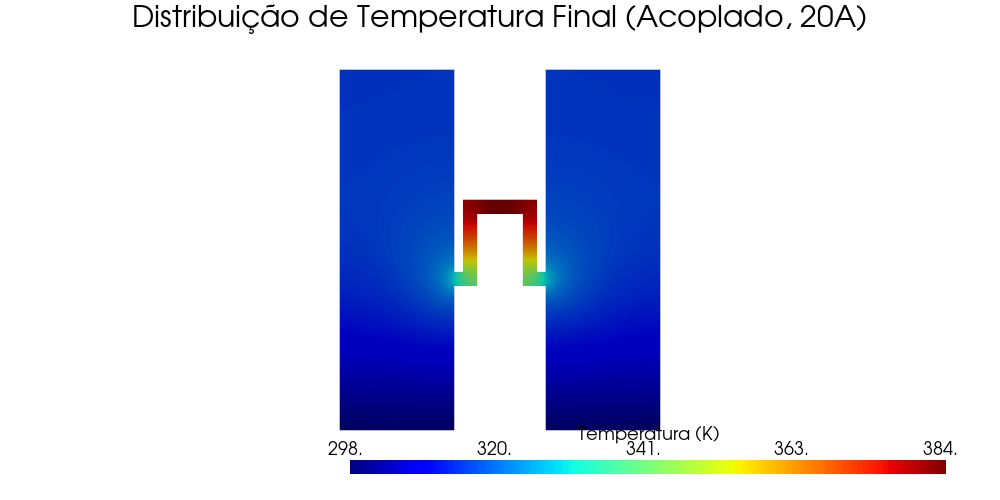

In [8]:
# =============================================================================
# 9. PLOT DA DISTRIBUIÇÃO DE TEMPERATURA (CASO 20A)
# =============================================================================
if T_sol_20A is not None:
    print("\nPlotando a distribuição de temperatura final para o caso de 20A (Acoplado)...")
    pyvista.start_xvfb()
    plotter_T_coupled = pyvista.Plotter(window_size=[1000, 500])
    grid_T_coupled = pyvista.UnstructuredGrid(*vtk_mesh(V_T))
    grid_T_coupled.point_data["Temperatura (K)"] = T_sol_20A.x.array
    plotter_T_coupled.add_mesh(grid_T_coupled, show_edges=False, cmap="jet", scalar_bar_args={'title': 'Temperatura (K)'})
    plotter_T_coupled.add_text("Distribuição de Temperatura Final (Acoplado, 20A)", position="upper_edge", font_size=12, color="black")
    plotter_T_coupled.view_xy()
    plotter_T_coupled.show()
else:
    print("\nNão foi possível gerar o plot de temperatura para 20A (simulação pode não ter incluído esse valor).")


Plotando a curva de condutividade média vs temperatura máxima (20A)...


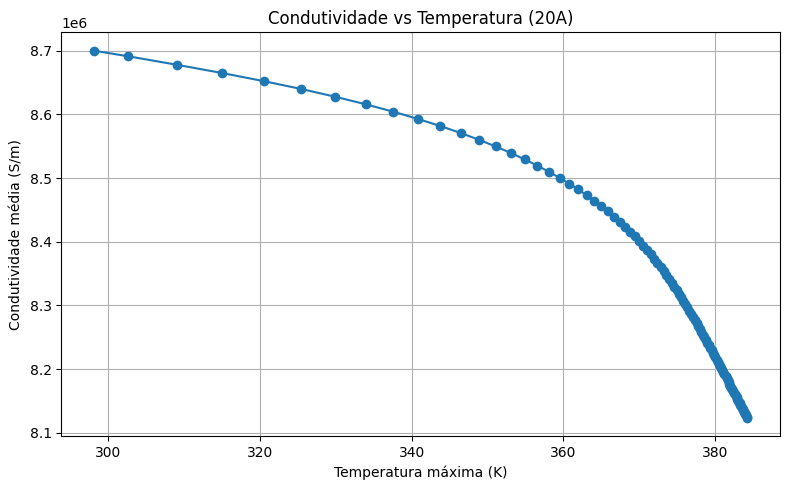

In [9]:
if sigma_mean_20A and T_max_20A:
    print("\nPlotando a curva de condutividade média vs temperatura máxima (20A)...")
    plt.figure(figsize=(8, 5))
    plt.plot(T_max_20A, sigma_mean_20A, marker='o', color='tab:blue')
    plt.xlabel("Temperatura máxima (K)")
    plt.ylabel("Condutividade média (S/m)")
    plt.title("Condutividade vs Temperatura (20A)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

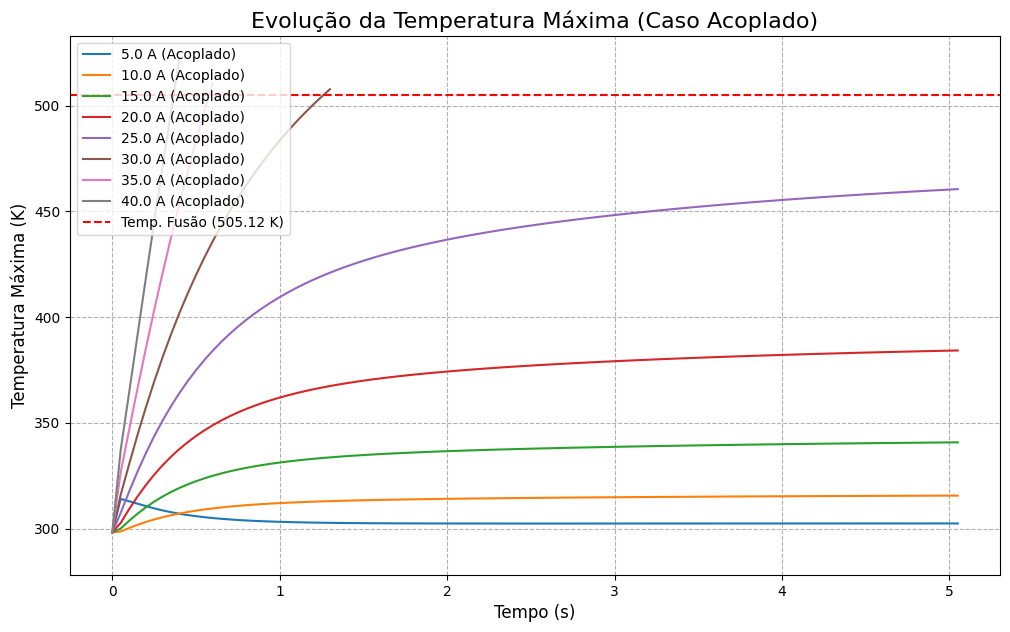

In [10]:
# =============================================================================
# 8. PLOT DO GRÁFICO TEMPO vs TEMPERATURA (ACOPLADO)
# =============================================================================

plt.figure(figsize=(12, 7))
for current, (times, temps) in results_coupled.items():
    plt.plot(times, temps, label=f'{current:.1f} A (Acoplado)')

plt.axhline(y=Tf, color='r', linestyle='--', label=f'Temp. Fusão ({Tf:.2f} K)')
plt.title('Evolução da Temperatura Máxima (Caso Acoplado)', fontsize=16)
plt.xlabel('Tempo (s)', fontsize=12)
plt.ylabel('Temperatura Máxima (K)', fontsize=12)
plt.legend()
plt.grid(True, which='both', linestyle='--')
plt.ylim(bottom=T_amb-20)
plt.show()